In [1]:
%load_ext autoreload
%autoreload 2

# Poiseuille Flow in a Pipe

In this notebook, we will solve the Stokes equation for steady state, pressure-driven flow through a pipe. The main point behind the example is to ensure that the framework is applicable in the case of mixed function spaces. 

The main equations for the problem reads as follows:
$$
\left\{
\begin{aligned}
    -\text{div}\left(\nabla u + p I \right) &= 0\\
    \text{div}(\mathbf{u}) &= 0 \\
    (\nabla u + pI) \cdot n & = p_{inflow} && on \Gamma_{out} \\
    (\nabla u + pI) \cdot n & = p_{outflow} && on \Gamma_{out}\\
    u &= 0 && on \Gamma_{wall}
\end{aligned}
\right.
$$

The boundary conditions specify the no-slip condition along the wall, as well as so-called fully developed flow: The flow profile does not change along the horizontal direction.

In addition to defining a more fitting domain for our problem, the main changes that are required for this problem, is finding a nice way to define the boundary conditions for dolfin subspaces. The solution ended up being the so-called "Indexed\*Boundary" which wraps either a variational or Dirichletboundary, with the aditional information of the index of the subpace for which the boundary condition applies to. 

While it does lead to some long naming conventions which could probably gain something from wrapping the definitions into functions, it does at least do the trick of correctly imposing the boundary. Additionally, I've come to realize that the TractionBoundary is basically just a NeumannBoundary, and that the TractionBoundary should probably be removed in the future.

In [2]:
from typing import Dict

import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import ufl
from dolfin import inner, grad, div

from pantarei import forms, solvers, mms, boundary, elements
from pantarei.boundary import *
from pantarei.domain import Domain

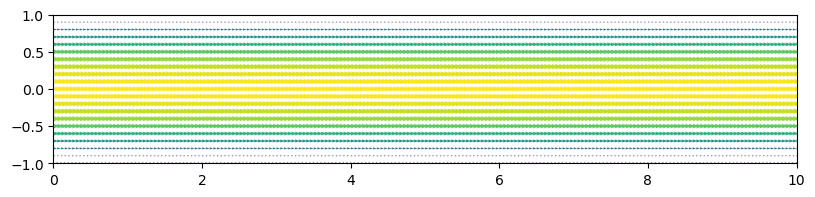

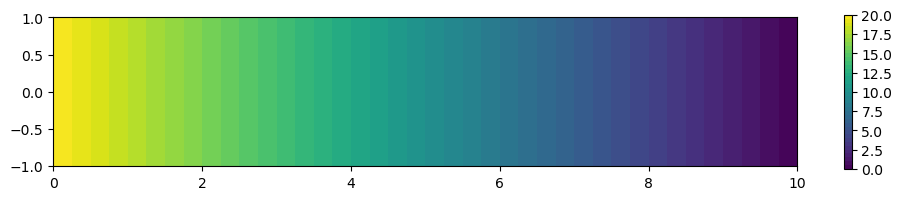

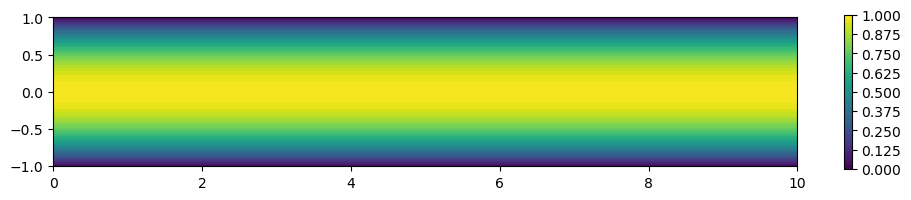

In [3]:
def pipe_domain(n: int, L: float = 5.0) -> Domain:
    mesh = df.RectangleMesh(df.Point(0, -1), df.Point(L, 1), int(n*L), n)
    inlet = df.CompiledSubDomain("near(x[0], 0.0) && on_boundary")
    outlet = df.CompiledSubDomain(f"near(x[0], {L}) && on_boundary")
    walls = df.CompiledSubDomain("(near(x[1], 1) || near(x[1], -1)) && on_boundary")

    boundaries = {
        1: inlet,
        2: outlet,
        3: walls
    }
    subdomains = mms.mark_subdomains({}, mesh, 0)
    boundary_tags = mms.mark_subdomains(boundaries, mesh, 1)
    return Domain(mesh, subdomains, boundary_tags)


def stokes_form():
    def create_fem_form(
        V: df.FunctionSpace,
        coefficients: Dict[str, ufl.Coefficient],
        boundaries: Dict[int, List[BoundaryData]]
    ) -> df.Form:
        u, p = df.TrialFunctions(V)
        v, q = df.TestFunctions(V)
        f = coefficients["f"] if "f" in coefficients else df.Constant((0.0, 0.0))
        dx = df.Measure("dx", V.mesh())
        F = (inner(grad(u), grad(v)) - p*div(v) - q*div(u)) * dx - (inner(f, v) * dx)
        return F + process_boundary_forms([u, p], [v, q], domain, boundaries)
    return create_fem_form

    
# Define the domain, and a Taylor hood element.
domain = pipe_domain(20, 10)
QV = df.VectorElement("CG", ufl.Cell('triangle'), 2)
LP = df.FiniteElement("CG", ufl.Cell('triangle'), 1)
element = df.MixedElement([QV, LP])

p_inflow = df.Constant(20.0)
p_outflow = df.Constant(0.0)
boundary_conditions = {
    0: [
        DirichletBoundary(df.Constant((0.0, 0.0)), 3), # Noslip
        NeumannBoundary(df.Constant((-p_inflow, 0)), 1),  # Input pressure
        NeumannBoundary(df.Constant((-p_outflow, 0)), 2),  # Output pressure
    ],
}
# Convert to IndexedBoundaryConditions
boundary_conditions = indexed_boundary_conditions(boundary_conditions)

problem = solvers.StationaryProblem(
    domain,
    element,
    coefficients={},
    form=stokes_form(),
    boundaries=boundary_conditions,
    solver=solvers.StationaryProblemSolver("lu", "none"),
    name="velocity-pressure"
)

UP = problem.solve()
u, p = UP.split(True)

plt.figure(figsize=(12, 1.93))
df.plot(u)
plt.xlim(0, 10)
plt.ylim(-1, 1)
plt.show()

plt.figure(figsize=(12, 2))
c = df.plot(p)
plt.colorbar(c)
plt.show()

ux, uy = u.split()
plt.figure(figsize=(12, 2))
c = df.plot(ux)
plt.colorbar(c)
plt.show()

## Time-Dependent

Now we will look at "Time-Dependent Stokes Flow", where we still use the same set of stationary equations, but with time-dependent coefficient. We will implement a pulsating inflow pressure and implement a time-dependent problem in light of this. The main intention behind this is to verify that most of the tools we have available for time-dependent equations work in the mixed functionspaces as well.

The inflow pressure will be given by the expression
$$
    p_{inflow}(t) = \bar p_{inflow} \cos(6\pi t)
$$

In [4]:
from pantarei.timekeeper import TimeKeeper
from pantarei.solvers import solve_time_dependent
from pantarei.fenicsstorage import FenicsStorage

In [5]:
dt = 0.01
T = 1.0
time = TimeKeeper(dt, T)

p_amplitude = df.Constant(20.0)
num_periods=3
p_inflow = df.Expression(("p * cos(N * pi * (t / T))", "0.0"), t=time, p=p_amplitude, N=num_periods, T=T, degree=0)
boundary_conditions = {
    0: [
        DirichletBoundary(df.Constant((0.0, 0.0)), 3), # Noslip
        NeumannBoundary(-p_inflow, 1),  # Input pressure
        NeumannBoundary(df.Constant((-p_outflow, 0)), 2),  # Output pressure
    ],
}
boundary_conditions = indexed_boundary_conditions(boundary_conditions)


time.reset()
storage = FenicsStorage("stokes-flow.hdf", "w")
computer = solve_time_dependent(
    domain=domain,
    element=element,
    coefficients={},
    form=stokes_form(),
    boundaries=boundary_conditions,
    initial_condition=lambda V, _: df.project(df.Constant((0.0, 0.0, 0.0)), V),
    time=time,
    solver=solvers.StationaryProblemSolver("lu", "none"),
    storage=storage,
    name="velocity-pressure",
    computer=None
)
storage.close()
storage = FenicsStorage("stokes-flow.hdf", "r")
storage.to_xdmf("velocity-pressure", ["velocity", "pressure"])
storage.close()